In [1]:
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import random

In [3]:
def compute_transition_matrix(graph):
    """Compute the transition probabilities for a random walk"""
    adjacency = nx.to_numpy_array(graph, dtype=float)  # Convert graph to adjacency matrix
    row_sums = adjacency.sum(axis=1, keepdims=True) # Row sums
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    return adjacency / row_sums  # Normalize rows to get transition probabilities

def simulate_random_walk(graph, transition_matrix, steps=100000):
    """Simulate a long random walk to estimate node visit frequencies"""
    nodes = list(graph.nodes)
    node_to_index = {node: idx for idx, node in enumerate(nodes)}  # Map nodes to their indices
    visit_counts = defaultdict(int) # Define a dictionary to store visit counts
    current_node = np.random.choice(nodes) # Start at a random node
    
    for _ in range(steps):
        visit_counts[current_node] += 1
        neighbors = list(graph.neighbors(current_node)) # Get neighbors of current node
        if neighbors:
            current_index = node_to_index[current_node]  # Find index of current node
            neighbor_indices = [node_to_index[n] for n in neighbors]  # Find indices of neighbors
            probabilities = np.array([transition_matrix[current_index, idx] for idx in neighbor_indices]) # Get transition probabilities
            probabilities /= probabilities.sum()  # Normalize probabilities
            current_node = np.random.choice(neighbors, p=probabilities) # Move to a neighbor based on probabilities
    
    total_visits = sum(visit_counts.values()) # Compute total number of visits for each node
    return {node: visit_counts[node] / total_visits for node in graph.nodes} # Normalize visit counts to get probabilities

def compute_map_equation(graph, transition_matrix, visit_probs, partition):
    """Compute the map equation for the current partitioning"""
    module_probs = defaultdict(float) # Initialize module probabilities
    teleport_term = defaultdict(float) # Initialize teleport probabilities
    non_teleport = defaultdict(float) # Initialize exit probabilities

    tau = 0.01  # Teleport probability
    node_to_index = {node: idx for idx, node in enumerate(graph.nodes)}
    #n = len(set(partition.values()))  # Count the number of unique partitions
    q = defaultdict(float)  # Initialize exit probabilities

    for node, module in partition.items():
        module_probs[module] += visit_probs[node] # Compute module probabilities as sum of visit probabilities 
        #ni = sum(1 for m in graph.nodes if partition[m] == module)  # Count nodes in the partition
        #teleport_term[module] += tau * (n - ni) / (n-1) * visit_probs[node] 
        teleport_term[module] += 0
        for neighbor in graph.neighbors(node): 
            if partition[neighbor] != module: # If neighbor is in a different module
                node_idx = node_to_index[node] # Get index of current node
                neighbor_idx = node_to_index[neighbor]  # Get index of neighbor
                non_teleport[module] +=  (1 - tau) * visit_probs[node] * transition_matrix[node_idx, neighbor_idx]  # Compute exit probabilities

    for module in module_probs.keys():
        q[module] = teleport_term[module] + non_teleport[module]  # Compute exit probabilities

    
    def safe_log2(x):
        return np.log2(x) if x > 0 else 0

    '''
    first_term = sum(q[module] for module in module_probs.keys()) * np.log2(sum(q[module] for module in module_probs.keys()))
    second_term = - 2 * sum(q[module]*np.log2(q[module]) for module in module_probs.keys())
    third_term = - sum(visit_probs[node] * np.log2(visit_probs[node]) for node in graph.nodes)
    fourth_term = sum(q[module] *  sum(visit_probs[node] for node in graph.nodes if partition[node] == module) * np.log2(q[module] * sum(visit_probs[node] for node in graph.nodes if partition[node] == module)) for module in module_probs.keys())
    '''
    first_term = sum(q[module] for module in module_probs.keys()) * safe_log2(sum(q[module] for module in module_probs.keys()))
    second_term = - 2 * sum(q[module] * safe_log2(q[module]) for module in module_probs.keys())
    third_term = - sum(visit_probs[node] * safe_log2(visit_probs[node]) for node in graph.nodes)
    fourth_term = sum((q[module] + module_probs[module]) * (safe_log2(q[module] + module_probs[module])) for module in module_probs.keys())

    description_length = first_term + second_term + third_term + fourth_term

    return description_length # Return the map equation

def optimize_partition(graph, transition_matrix, iterations):
    """Optimize the partitioning to minimize the map equation"""
    visit_probs = simulate_random_walk(graph, transition_matrix)

    partition = {node: node for node in graph.nodes}  # Start with each node as its own module
    for _ in range(iterations):
        for node in graph.nodes:
            best_module = partition[node] # Initialize best module as current module
            best_score = compute_map_equation(graph, transition_matrix, visit_probs, partition) 

            for neighbor in graph.neighbors(node): # Try moving node to each neighbor's module
                partition[node] = partition[neighbor] # Move node to neighbor's module
                new_score = compute_map_equation(graph, transition_matrix, visit_probs, partition) # Compute new map equation score
                if new_score <= best_score: # If new score is better, update best module and score
                    best_module = partition[node]
                    best_score = new_score

            partition[node] = best_module  # Keep the best move
    return partition

def greedy_optimize_partition(graph, transition_matrix, visit_probs, iterations):
    """Greedy search to minimize the map equation by merging best modules."""

    # Start with each node as its own module
    partition = {node: node for node in graph.nodes}
    
    for _ in range(iterations):
        improved = False
        module_list = list(set(partition.values()))  # Get unique communities
        
        for i in range(len(module_list)):  # Merging each pair of communities and see if it improves the map equation
            for j in range(len(module_list)):  # Compare each pair
                if i != j:  # Skip if same community
                    temp_partition = partition.copy() # Temporary partition where we merge module j into module i
                    for node in graph.nodes:
                        if partition[node] == module_list[j]:  
                            temp_partition[node] = module_list[i] # Merge module j into module i
                    
                    old_score = compute_map_equation(graph, transition_matrix, visit_probs, partition) # Compute old map equation
                    new_score = compute_map_equation(graph, transition_matrix, visit_probs, temp_partition) # Compute new map equation
                    
                    if new_score < old_score:  # If merging improves score
                        partition = temp_partition  # Apply the merge
                        improved = True
        
        if not improved:  # Stop if no improvement
            break
    return partition


def simulated_annealing_infomap(graph, transition_matrix, visit_probs, partition, num_iterations):
    """Refine Infomap partition using simulated annealing with heat-bath algorithm."""

    T_start = 5.0    
    T_end = 0.001    
    cooling_rate = 0.99  

    best_partition = partition.copy()
    current_partition = partition.copy()
    best_score = compute_map_equation(graph, transition_matrix, visit_probs, best_partition)
    current_score = best_score

    T = T_start  

    while T > T_end:
        for _ in range(num_iterations):
            node = random.choice(list(graph.nodes))
            current_community = current_partition[node]
            possible_communities = list(set(current_partition.values()) - {current_community})

            if not possible_communities:
                continue  
            
            new_community = random.choice(possible_communities)

            temp_partition = current_partition.copy()
            temp_partition[node] = new_community
            
            new_score = compute_map_equation(graph, transition_matrix, visit_probs, temp_partition)
            delta_L = new_score - current_score  
            
            if delta_L < 0 or np.exp(-delta_L / T) > random.random():
                current_partition = temp_partition.copy()
                current_score = new_score
                
                if new_score < best_score:
                    best_partition = current_partition.copy()
                    best_score = new_score
        
        T *= cooling_rate

    return best_partition

def plot_communities(graph, partition):
    """Plot the network with different colors for different communities"""
    plt.figure(figsize=(10, 7))
    
    # Create a color map for each community
    unique_communities = list(set(partition.values()))
    colors = ["red", "blue", "green", "purple", "orange", "yellow", "black", "gray", "pink", "brown"]
    community_colors = {community: colors[i] for i, community in enumerate(unique_communities)}

    # Assign colors to nodes based on their community
    node_colors = [community_colors[partition[node]] for node in graph.nodes]

    # Draw the graph
    pos = nx.spring_layout(graph, seed=42)  # Layout for visualization
    nx.draw(graph, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.5)
    
    plt.title("Detected Communities in the Network")
    plt.show()

def plot_communities_sbm(graph, partition):
    """Plot SBM network with different colors for different communities"""
    plt.figure(figsize=(10, 7))
    
    # Identify unique communities and assign colors using the 'turbo' colormap
    unique_communities = list(set(partition.values()))
    #colors = plt.cm.turbo(np.linspace(0, 1, len(unique_communities)))
    colors = ["red", "blue", "green", "purple", "orange", "yellow", "black", "gray", "pink", "brown", "cyan", "magenta", "lime", "navy", "teal", "coral"]
    community_colors = {community: colors[i] for i, community in enumerate(unique_communities)}
    
    # Assign colors to nodes based on their community
    node_colors = [community_colors[partition[node]] for node in graph.nodes]

    # Use the multipartite layout for SBM
    pos = nx.multipartite_layout(graph, subset_key="block")

    # Draw the graph
    nx.draw(graph, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.5)
    
    plt.title("Detected Communities in SBM")
    plt.show()

In [10]:
# Parameters
num_communities = 5
total_nodes = 100

# Set a random seed for reproducibility
np.random.seed(42)

# Generate unequal community sizes
# The sizes will be sampled from a distribution (e.g., power law or uniform)
community_sizes = np.random.randint(50, 200, num_communities)
community_sizes = community_sizes / np.sum(community_sizes) * total_nodes  # Normalize to total_nodes

# Create the probability matrix (block matrix)
# Intra-community probabilities (higher for larger communities)
p_in = np.random.uniform(0.3, 0.6, num_communities)
# Inter-community probabilities (smaller probabilities for edges between different communities)
p_out = np.random.uniform(0.005, 0.02, (num_communities, num_communities))

# Ensure the matrix is symmetric by mirroring the upper triangle into the lower triangle
p_out = np.triu(p_out) + np.triu(p_out, 1).T

np.fill_diagonal(p_out, p_in)

# Generate the stochastic block model graph with unequal community sizes
G = nx.stochastic_block_model(community_sizes.astype(int), p_out, seed=42)

In [11]:
transition_matrix = compute_transition_matrix(G)
visit_probs = simulate_random_walk(G, transition_matrix)

## Greedy search

In [ ]:
greedy_partition = greedy_optimize_partition(G, transition_matrix, visit_probs, iterations=100)

In [9]:

print("Number of communities detected:", len(set(greedy_partition.values())))
print("Communities detected:")
for node, module in sorted(greedy_partition.items()):
    print(f"Node {node} -> Community {module}")

#best_score = compute_map_equation(G, transition_matrix, greedy_partition)

plot_communities_sbm(G, greedy_partition)

Number of communities detected: 98
Communities detected:
Node 0 -> Community 0
Node 1 -> Community 1
Node 2 -> Community 2
Node 3 -> Community 3
Node 4 -> Community 4
Node 5 -> Community 5
Node 6 -> Community 6
Node 7 -> Community 7
Node 8 -> Community 8
Node 9 -> Community 9
Node 10 -> Community 10
Node 11 -> Community 11
Node 12 -> Community 12
Node 13 -> Community 13
Node 14 -> Community 14
Node 15 -> Community 15
Node 16 -> Community 16
Node 17 -> Community 17
Node 18 -> Community 18
Node 19 -> Community 19
Node 20 -> Community 20
Node 21 -> Community 21
Node 22 -> Community 22
Node 23 -> Community 23
Node 24 -> Community 24
Node 25 -> Community 25
Node 26 -> Community 26
Node 27 -> Community 27
Node 28 -> Community 28
Node 29 -> Community 29
Node 30 -> Community 30
Node 31 -> Community 31
Node 32 -> Community 32
Node 33 -> Community 33
Node 34 -> Community 34
Node 35 -> Community 35
Node 36 -> Community 36
Node 37 -> Community 37
Node 38 -> Community 38
Node 39 -> Community 39
Nod

IndexError: list index out of range

<Figure size 1000x700 with 0 Axes>

## Simulated Annealing

In [ ]:
final_partition = simulated_annealing_infomap(G, transition_matrix, visit_probs, greedy_partition, num_iterations=1000)

Number of communities detected: 10


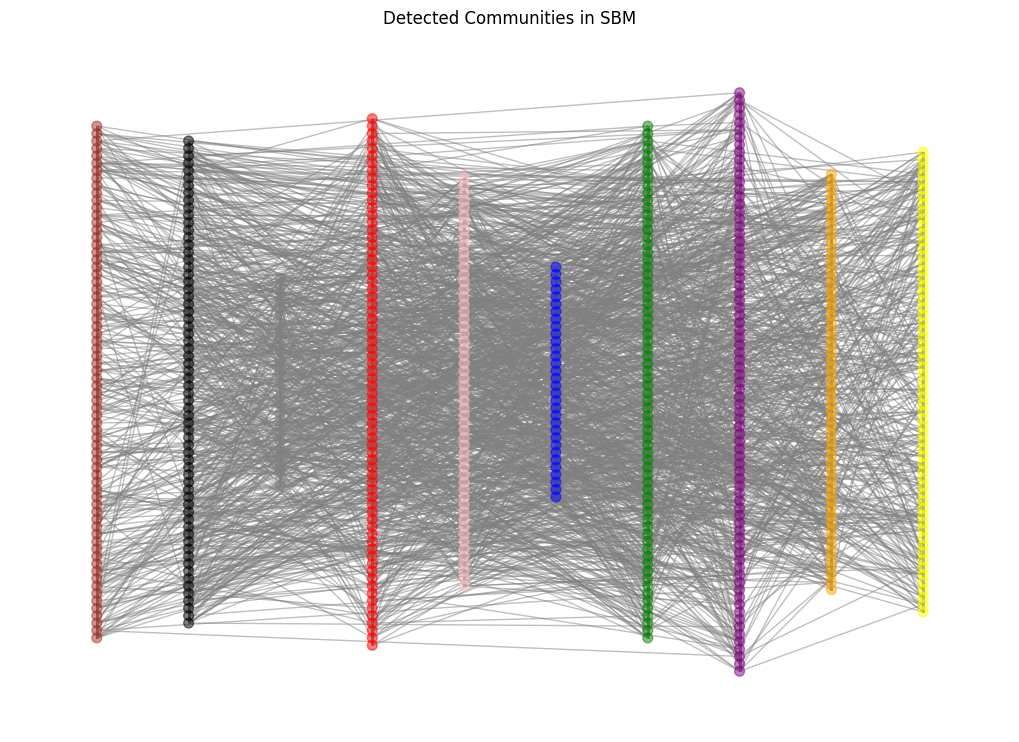

In [ ]:
#final_score = compute_map_equation(G, transition_matrix, final_partition)

print("Number of communities detected:", len(set(final_partition.values())))
#print("Greedy partition map equation:", best_score)
#print("Final partition map equation:", final_score)

# Plot the detected communities
plot_communities_sbm(G, final_partition)

provsa